# Q-Learning Algorithm






## Step 1: Install Gymnasium dependencies

In [2]:
!pip install gymnasium


## Step 2: Choose the environment
At this stage, to set the environment up, you just need to pass the name of the environment to the `make()` function.

We will consider the `FrozenLake-v1` environment.

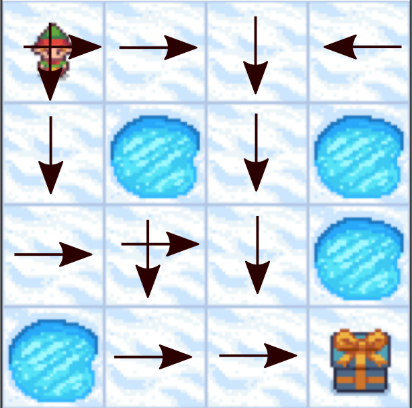

---
The goal of this game is <b>to go from the starting state to the goal state </b> by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, **so you won't always move in the direction you intend (stochastic environment).**

We will compute the optimal policy using the Q-learning algorithm.

Let's initialize our new environment.



In [3]:
import gymnasium as gym
# provide the name of the environment
env_name = 'FrozenLake-v1'
env = gym.make(env_name)

## Step 3: Check the state and action spaces

In [4]:
# check what the action space is
print("The action space is", env.action_space)
# check what the state space is
print("The observation (state) space is", env.observation_space)
# other factors are embedded in the environment

The action space is Discrete(4)
The observation (state) space is Discrete(16)


The Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0, 1, 2, or 3. The Box space represents an *n*-dimensional box, so valid observations will be an integer from 0 to 15 (representing the 16 positions on the 4x4 grid).

The transition probabilities and the rewards are not available at the beginning of the game. They are explored as the game is played.

# Implement Q-Learning

## Reminder: agent-environment interaction in Gymnasium


Remember what happens in each iteration in the agent-environment loop?

![agent-environment loop](https://miro.medium.com/max/1516/1*Z2yMvuQ1-t5Ol1ac_W4dOQ.png)

Gymnasium has a unified environment interface `Env` that we can interact with. The following are the `Env` methods you should know:



*   `reset(self)`: Reset the environment's state. Returns `observation` and `info`.
*   `step(self, action)`: Step the environment by one timestep. Returns `observation`, `reward`, `terminated`, `truncated`, `info`.
*    `render(self)`: Render one frame of the environment. Requires setting render_mode when creating the environment.






### The code skeleton

We need first to sample the initial state or observation. We start by calling `reset()`, which returns an initial observation and info. Then, at each *timestep*, the agent chooses an *action*, and the environment returns an *observation*, *reward*, *terminated*, *truncated*, and *info*.

In code (random actions are chosen):

```python
env = gym.make('CartPole-v1', render_mode="human") # setup the environment

observation, info = env.reset() # initialize --> initial observation
for i_episode in range(100): # 100 timesteps
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action) # take a random action
    done = terminated or truncated
    if done:
      break
env.close()
```


## Step 4: Computing optimal policy using Q-learning

Q-learning is a special implementation of the value-iteration algorithm we learned in the slides. Instead of computing one optimal value for each state, we compute $n$ values where $n$ is the size of the actions space, *i.e. the number of allowed actions*.

The Q-learning pseudo-code is as follows:

---

- Initialize the Q-values table $q$ to 0 for all $(s,a)$ pairs.
- $s = s_0$
- Repeat of $H$ steps
    -    $r$ = random_number()
    -    if r > exploration_rate:
        - $a$ = action that gives with highest $q(s,a)$
    -    else:
        - $a$ = random action
    - record the next state $s'$ and the reward $r$
    - $q[s, a] = q[s, a] + \alpha \times (r + \gamma \times max(q[s', :]) - q[s, a])$
    - $q[s, a] = (1 - \alpha) q[s, a] + \alpha \times (r + \gamma \times max(q[s', :]) $
    - $s = s'$
        

---
- For this purpose, we first need to construct a table `qtable` of size `state_size` x `action_size` such that `qtable[s,a]` is Q(s,a). For that, we need to calculate the action_size and the state_size which are provided by Gymnasium through `env.action_space.n` and `env.observation_space.n`.

In [6]:
import numpy as np

# check the action space dimension and the state space dimension
action_size = env.action_space.n
state_size = env.observation_space.n

# Create our Q table with state_size rows and action_size columns (16x4)
# qtable[i,j] is the qvalue of the state i when executing action j
qtable = np.zeros((state_size, action_size))


We can check the `qtable` so far.

In [7]:
# check the qtable
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


First, we initialize the hyperparameters of our learning algorithm.

In [17]:
total_episodes = 10000       # Total episodes
learning_rate = 0.7          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.99                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.005            # Exponential decay rate for exploration prob

Next, we implement the Q-learning algorithm to compute the optimal Q-values.

In [19]:
# import the random package
import random

# List of rewards -- initially empty
rewards = []

# loop until the total number of episodes is reached
for episode in range(total_episodes):
    # Reset the environment
    state, info = env.reset()
    # assume that the game is not done
    terminated = False
    truncated = False
    # sum the total_rewards
    total_rewards = 0

    # loop max_steps times
    for step in range(max_steps):
        # Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon --> exploitation
        ##                                      (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        ## Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()


        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

        total_rewards += reward

        # Our new state is state
        state = new_state

        # If done : finish episode
        if done:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)

# print the score
print ("Score over time: " +  str(sum(rewards)/total_episodes))


Score over time: 0.5149


We can check the newly computed Q-values.

In [10]:
# print updated qtable
print(qtable)

[[3.23101238e-02 2.97756137e-02 2.95858992e-02 3.05122843e-02]
 [1.86220113e-02 1.72056391e-02 4.61091245e-03 3.13381277e-02]
 [8.13491493e-03 1.56387661e-02 1.96437570e-02 1.91687351e-02]
 [1.37142691e-02 4.41819855e-03 6.79848578e-03 2.12851719e-02]
 [3.20375741e-02 2.85486610e-02 2.65283868e-02 1.34023162e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.65370858e-05 6.39237543e-06 6.98114614e-04 1.99657514e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.55180417e-02 1.06769949e-02 1.06117406e-02 3.07719866e-01]
 [1.60917938e-02 1.91156482e-02 1.28969663e-02 2.66472259e-01]
 [5.99549255e-02 3.85169663e-03 1.19128948e-03 3.21841247e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.38371105e-03 9.76999900e-02 3.46425213e-01 4.51057925e-02]
 [2.27252062e-01 2.45021280e-01 1.68216583e-01 9.93169414e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

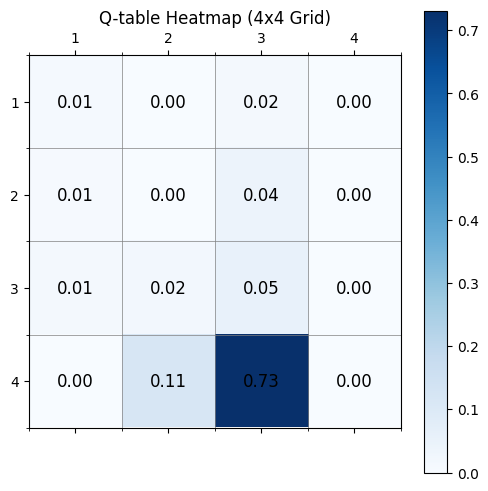

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Find the maximum Q-value in each state (row)
max_q_values = np.max(qtable, axis=1)

# Reshape the max_q_values to a 4x4 grid (16 states in a 4x4 grid)
grid = max_q_values.reshape(4, 4)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(grid, cmap='Blues')  # You can choose another colormap like 'inferno'

# Add color bar
fig.colorbar(cax)


best_action = {
    0: '',
    1: 'right'
}
# Labeling the grid
for i in range(4):
    for j in range(4):
        ax.text(j, i, f'{grid[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)

        # action = np.argmax(qtable[state,:])


# Set the ticks to match the grid
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(np.arange(1, 5))
ax.set_yticklabels(np.arange(1, 5))

# Turn off the gridlines
ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

plt.title('Q-table Heatmap (4x4 Grid)')
plt.show()


## Step 5: Testing the optimal policy
Now, we can play a few episodes of the game using the optimal policy we just computed. Our Q-table can be used as a "cheatsheet" to play FrozenLake.


In [21]:
# Create environment with rendering for testing
env = gym.make(env_name, render_mode="human")

# do 5 episodes
for episode in range(5):
    state, info = env.reset()
    terminated = False
    truncated = False
    print("****************************************************")
    print("EPISODE ", episode)

    # do max_steps
    for step in range(max_steps):

        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])

        # execute that action
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # if we are done
        if done:
            # Check if our agent reached the goal or fell into a hole
            if new_state == 15:
                print("We reached our Goal")
            else:
                print("We fell into a hole")

            # We print the number of step it took.
            print("Number of steps", step)

            break
        # update state
        state = new_state
env.close()

****************************************************
EPISODE  0
We reached our Goal
Number of steps 67
****************************************************
EPISODE  1
We reached our Goal
Number of steps 17
****************************************************
EPISODE  2
We reached our Goal
Number of steps 16
****************************************************
EPISODE  3
We reached our Goal
Number of steps 90
****************************************************
EPISODE  4
We reached our Goal
Number of steps 11


## Step 6: Make sure to understand the code


Go back to the code and
*   Change exploration rate and observe its effect
*   Compare your policy to the random agent we implemented previously



# Extend to other environments/algorithms

We have defined the environment completely within Gymnasium and have the optimal policy calculated using the Q-learning algorithm.

Now, you probably want to learn new reinforcement learning algorithms and apply them to the `FrozenLake` environment or other environments.


You want your agent to make actions according to a policy computed by a different algorithm.
Thus, instead of

```
action = np.argmax(qtable[state,:])
```

you can choose the action that is dictated by the policy computed by your new algorithm.

----
# References



1.    [Gymnasium Documentation](https://gymnasium.farama.org/)

2.   [Gymnasium Environments](https://gymnasium.farama.org/environments/classic_control/)

3.   [Q-Learning with FrozenLake](https://colab.research.google.com/github/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q_Learning_with_FrozenLakev2.ipynb#scrollTo=JEtXMldxQ7uw)
